In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
import seaborn as sns

In [ ]:
#upload dataset
from google.colab import files
dataset = files.upload()

Saving datacuaca_fix.csv to datacuaca_fix.csv


In [ ]:
# Baca dataset cuaca Anda
# Pastikan dataset Anda memiliki kolom dengan atribut cuaca dan tanggal/waktu
# Baca dataset timeseries yang berisi kecepatan angin, suhu, dan jarak pandang
combined_data = pd.read_csv('datacuaca_fix.csv')

combined_data

# Urutkan data berdasarkan kolom Tanggal (jika perlu)
combined_data['date (yyyy-MM-dd HH:mm:ss)'] = pd.to_datetime(combined_data['date (yyyy-MM-dd HH:mm:ss)'])
combined_data = combined_data.sort_values(by='date (yyyy-MM-dd HH:mm:ss)')

combined_data

,date (yyyy-MM-dd HH:mm:ss),wind_speed,luminance_lvl,temperature,humidity,atmosphere_pressure,visibility,cloud_cover
0,2023-06-01 00:00:00,1.2,2796.0,26.2,100.0,1011.6,4550.0,1227.0
1,2023-06-01 00:01:00,1.3,2818.0,26.2,100.0,1011.6,4620.0,196.0
2,2023-06-01 00:02:00,1.2,2844.0,26.2,100.0,1011.6,4620.0,196.0
3,2023-06-01 00:03:00,0.9,2874.0,26.3,100.0,1011.6,4690.0,196.0
4,2023-06-01 00:04:00,0.8,2900.0,26.3,100.0,1011.6,4620.0,1292.0
...,...,...,...,...,...,...,...,...
123831,2023-08-31 23:55:00,3.2,3550.0,25.5,67.7,1012.8,20000.0,0.0
123832,2023-08-31 23:56:00,3.3,3588.0,25.6,67.6,1012.8,18750.0,3322.0
123833,2023-08-31 23:57:00,3.3,3622.0,25.6,67.3,1012.8,21430.0,3339.0
123834,2023-08-31 23:58:00,3.2,3653.0,25.7,67.1,1012.8,23080.0,0.0


In [ ]:
# Pilih atribut-atribut yang akan Anda gunakan
selected_features = ['wind_speed', 'temperature', 'atmosphere_pressure', 'luminance_lvl', 'cloud_cover','humidity', 'visibility']

# Mengisi data yang kosong dalam dataset dengan interpolasi linear
combined_data[selected_features] = combined_data[selected_features].interpolate(method='linear')

<ipython-input-5-9dd59f63c8b4>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(combined_data.corr(), cmap="RdBu",annot=True) #untuk mengerti korelasi data terhadap penelitian yang dilakukan


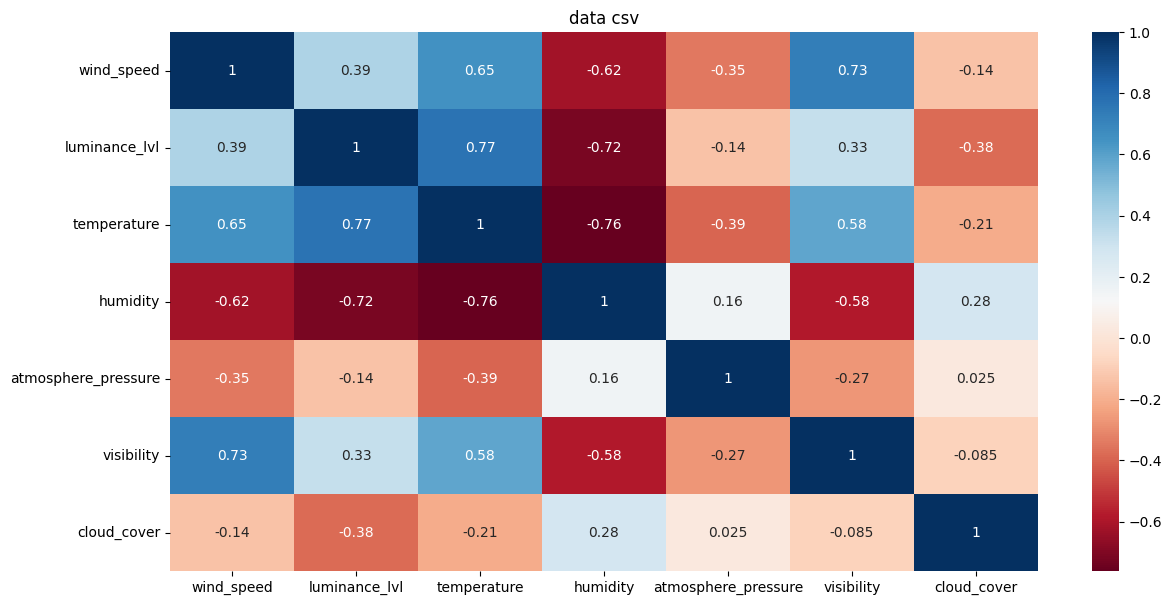

In [ ]:
#Heatmap
plt.figure(figsize=(14,7))
plt.title("data csv")
sns.heatmap(combined_data.corr(), cmap="RdBu",annot=True) #untuk mengerti korelasi data terhadap penelitian yang dilakukan
plt.show()

In [ ]:
# Normalisasi data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Normalize input features
combined_data[['wind_speed', 'temperature', 'atmosphere_pressure', 'luminance_lvl', 'cloud_cover', 'humidity','visibility']] = scaler_X.fit_transform(combined_data[['wind_speed', 'temperature', 'atmosphere_pressure', 'luminance_lvl', 'cloud_cover', 'humidity','visibility']])

# Normalize target variable
combined_data[['target']] = scaler_y.fit_transform(combined_data[['visibility']])


In [ ]:
# Pisahkan data menjadi data pelatihan dan data validasi/test
train_size = int(len(combined_data) * 0.8)
train_data = combined_data.iloc[:train_size]
val_data = combined_data.iloc[train_size:]

In [ ]:
# Fungsi untuk menghasilkan sekuens deret waktu
def create_sequences(combined_data, seq_length):
    sequences = []
    targets = []

    for i in range(len(combined_data) - seq_length):
        seq_wind_speed = combined_data['wind_speed'].values[i:i + seq_length]
        seq_temperature = combined_data['temperature'].values[i:i + seq_length]
        seq_humidity = combined_data['humidity'].values[i:i + seq_length]
        seq_visibility = combined_data['visibility'].values[i:i + seq_length]

        seq = np.column_stack((seq_wind_speed, seq_temperature,  seq_humidity, seq_visibility))

        target = combined_data['target'].values[i + seq_length]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)
# Definisikan panjang sekuens dan buat sekuens dan targetnya
seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)

In [ ]:
print("X_train: ", X_train.shape)
print("X_test: ", X_val.shape)

X_train:  (105968, 10, 4)
X_test:  (26485, 10, 4)


In [ ]:
# Bangun model GRU
model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(seq_length, 4)))  # 6 adalah jumlah atribut input
model.add(Dense(1, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')

In [ ]:
# Latih model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/30
1656/1656 [==============================] - 42s 26ms/step - loss: 0.0160 - val_loss: 0.0151
Epoch 2/30
1656/1656 [==============================] - 39s 24ms/step - loss: 0.0160 - val_loss: 0.0152
Epoch 3/30
1656/1656 [==============================] - 42s 25ms/step - loss: 0.0160 - val_loss: 0.0151
Epoch 4/30
1656/1656 [==============================] - 40s 24ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 5/30
1656/1656 [==============================] - 42s 25ms/step - loss: 0.0160 - val_loss: 0.0151
Epoch 6/30
1656/1656 [==============================] - 41s 25ms/step - loss: 0.0160 - val_loss: 0.0151
Epoch 7/30
1656/1656 [==============================] - 42s 25ms/step - loss: 0.0160 - val_loss: 0.0150
Epoch 8/30
1656/1656 [==============================] - 41s 25ms/step - loss: 0.0159 - val_loss: 0.0151
Epoch 9/30
1656/1656 [==============================] - 40s 24ms/step - loss: 0.0159 - val_loss: 0.0151
Epoch 10/30
1656/1656 [==============================] - 42s 25m

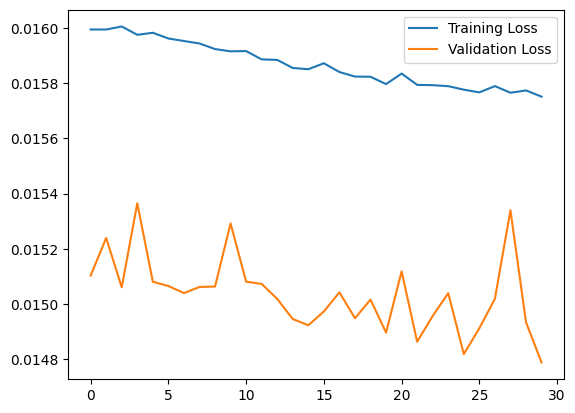

In [ ]:
# Plot loss training dan validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

val_predict = model.predict(X_val)
Y_val_pred = scaler_y.inverse_transform(val_predict.reshape(-1, 1))

# Invers normalize the true values
y_val_true = scaler_y.inverse_transform(y_val.reshape(-1, 1))

# Calculate predictions on original scale
mse = mean_squared_error(y_val_true, Y_val_pred)
mae = mean_absolute_error(y_val_true, Y_val_pred)
r2 = r2_score(y_val_true, Y_val_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

828/828 [==============================] - 3s 3ms/step
Mean Squared Error (MSE): 0.0010342644334065108
Mean Absolute Error (MAE): 0.014788125654512287
R-squared (R2): 0.9713355504762824


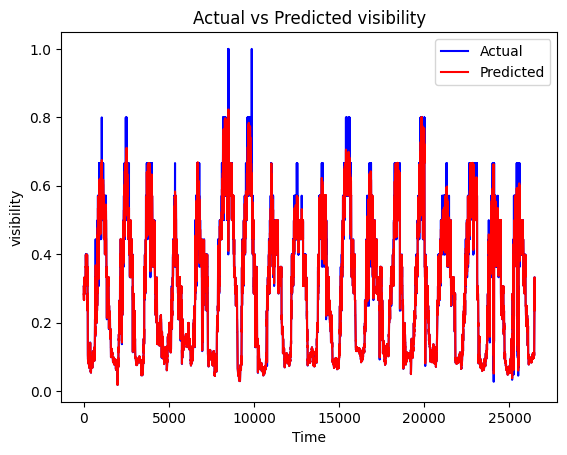

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_val_true, label='Actual', color='blue')
plt.plot(Y_val_pred, label='Predicted', color='red')

plt.title('Actual vs Predicted visibility')
plt.xlabel('Time')
plt.ylabel('visibility')
plt.legend()
plt.show()

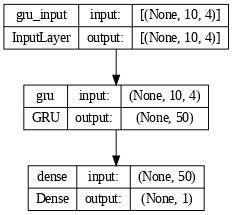

In [ ]:
!pip install pydotplus
!pip install graphviz

from tensorflow.keras.utils import plot_model

plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)